# Курсовая работа № 2
## Аналитика. Начальный уровень

## Часть вторая

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://colab.research.google.com/drive/1rRaTay-OSPLAOX8V9UaFvTiAciVtp2s3).

In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import requests
import numpy as np

In [ ]:
# Подключаемся к паблику Skillbox Вконтакте

# https://oauth.vk.com/authorize?client_id=XXX&display=page&redirect_uri=http://oauth.vk.com/blank.html&scope=all&response_type=token

vk_token = 'YYY'
url = 'https://api.vk.com/method/account.getProfileInfo?access_token=' + str(vk_token) + '&v=5.92'
response = requests.get(url).json()
print(response)

In [ ]:
# получаем последнюю запись из паблика Skillbox Вконтакте
url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + '&owner_id=-66669811&count=1&v=5.92'
response = requests.get(url).json()
response

In [4]:
# Изучим ее структуру
response['response'].keys()

dict_keys(['count', 'items'])

In [5]:
# 'items' - это список из одного элемента, который является словарем с 14ю ключами.
# Они то нам и нужны
response['response']['items'][0].keys()

dict_keys(['id', 'from_id', 'owner_id', 'date', 'marked_as_ads', 'post_type', 'text', 'attachments', 'post_source', 'comments', 'likes', 'reposts', 'views', 'is_favorite'])

### Прочитаем из паблика SkillBox посты с октября 2019 года по ноябрь 2020 года включительно.

Интересно сравнить как измененилась посещаемость и активность пользователей в октябре-ноябре 2020 года, по сравнению с аналогичным периодом 2019 года, а также оценить влияние введенных в стране и мире ограничительных мер в связи с коронавирусной инфекцией.

In [6]:
# Объявим пустые списки для последующего создания датафрейма
list_id = []
list_date_int = []
list_likes = []
list_reposts = []
list_views = []
list_comments = []
list_text = []

# Считываем записи с ноября 2019 года
dt = '2020-12-31'
i = 1
while dt > '2019-10-01':
    url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + \
        '&owner_id=-66669811&count=100' + \
        '&offset=' + str((i-1)*100+1) + \
        '&v=5.92'
    response = requests.get(url).json()
    dt = response['response']['items'][99]['date']
    dt = (datetime.fromtimestamp(dt) - timedelta(hours=0)).strftime('%Y-%m-%d')

    # Запоминаем данные в списки
    for j in range(0,100):
        list_id.append(response['response']['items'][j]['id'])
        list_date_int.append(response['response']['items'][j]['date'])
        list_likes.append(response['response']['items'][j]['likes']['count'])
        list_reposts.append(response['response']['items'][j]['reposts']['count'])
        list_views.append(response['response']['items'][j]['views']['count'])
        list_comments.append(response['response']['items'][j]['comments']['count'])
        list_text.append(response['response']['items'][j]['text'].replace('$', ' '))

    i += 1

In [7]:
# Здесь мы записываем полученные данные в датафрейм
df = pd.DataFrame(columns = ['id', 'date_int', 'likes', 'reposts', 'views', 'comments', 'text'])
df['id'] = list_id
df['date_int'] = list_date_int
df['likes'] = list_likes
df['reposts'] = list_reposts
df['views'] = list_views
df['comments'] = list_comments
df['text'] = list_text

In [8]:
# Сохраняем полученный датафрейм в csv файл
# df.to_csv('Course2-2.csv', sep='$', index_label='index')

# Читаем сохраненные данные из csv файла
# df = pd.read_csv('Course2-2.csv', sep='$', index_col='index')

In [9]:
# ДОБАВЛЯЕМ В ДАТАФРЕЙМ НУЖНЫЕ СТОЛБЦЫ
# Дата в полном формате
# df['date_full'] = df['date_int'].apply( lambda x: (datetime.fromtimestamp(x) - timedelta(hours=0)).strftime('%Y-%m-%d %H:%M:%S'))
# Дата в коротком формате
df['date'] = df['date_int'].apply( lambda x: (datetime.fromtimestamp(x) - timedelta(hours=0)).strftime('%Y-%m-%d'))
# Часы
df['time'] = df['date_int'].apply( lambda x: (datetime.fromtimestamp(x) - timedelta(hours=0)).strftime('%H'))

# Дата в формате Год-месяц
df['y_m'] = df['date_int'].apply( lambda x: (datetime.fromtimestamp(x) - timedelta(hours=0)).strftime('%Y-%m'))

# Дата в формате день месяца
df['day'] = df['date_int'].apply( lambda x: (datetime.fromtimestamp(x) - timedelta(hours=0)).strftime('%d'))

# День недели
df['wd'] = df['date_int'].apply( lambda x: (datetime.fromtimestamp(x) - timedelta(hours=0)).strftime('%a'))

In [10]:
# Сохраняем в дополнительный датафрейм данные по ноябрю 2019 и по ноябрю 2020
df_small = df[ ((df['date'] >= '2019-10-01') & (df['date'] <= '2019-10-31')) | ((df['date'] >= '2020-10-01') & (df['date'] <= '2020-10-31'))].reset_index()
df_small.head(5)

,index,id,date_int,likes,reposts,views,comments,text,date,time,y_m,day,wd
0,93,119665,1604151093,63,4,51591,4,2020 год заставил бренды подстраиваться под но...,2020-10-31,17,2020-10,31,Sat
1,94,119541,1604047539,148,4,53528,16,"А что, если бы злодеи из фильмов ужасов записа...",2020-10-30,12,2020-10,30,Fri
2,95,119453,1603980020,79,12,40060,2,"Иллюстратор рисует иллюстрации, вроде всё прос...",2020-10-29,18,2020-10,29,Thu
3,96,119411,1603962834,266,46,42646,0,У фотографов муза — ну очень капризная!\n\nОна...,2020-10-29,13,2020-10,29,Thu
4,97,119304,1603897268,90,11,34556,23,Не стоит искать свободы в творческих профессия...,2020-10-28,19,2020-10,28,Wed


In [11]:
# Фильтруем данные по нужному периоду - с декабря 2019 по ноябрь 2020
df = df[ (df['date'] >= '2019-12-01') & (df['date'] <= '2020-11-30')].reset_index()
df.head()

,index,id,date_int,likes,reposts,views,comments,text,date,time,y_m,day,wd
0,57,127989,1606750233,72,10,26006,0,"KPI — это показатели, по которым клиент или ра...",2020-11-30,19,2020-11,30,Mon
1,58,127974,1606742323,72,7,30828,5,Вас ждет насыщенная неделя! Научим вас проекти...,2020-11-30,17,2020-11,30,Mon
2,59,127766,1606723435,143,3,40089,28,«Свой парень на районе» — айдентика Okolo. Слу...,2020-11-30,12,2020-11,30,Mon
3,60,127754,1606652616,335,39,49255,16,Как бы написали слово «ёлка» в XVIII веке? Не ...,2020-11-29,16,2020-11,29,Sun
4,61,127630,1606566183,82,16,28695,0,Свежая подборка бесплатных шрифтов! Пополняйте...,2020-11-28,16,2020-11,28,Sat


Мы сформировали таблицы с требуемыми данными. Теперь займемся анализом.

Под показателями активности пользователей будем понимать:
- количество просмотров поста
- количество поставленных под постом лайков
- количество репостов поста
- количество сделанных к посту комментариев

Проанализируем динамику показателей активности и попытаемся найти зависимость активности посетителей Паблика:
1. По месяцам
2. По дням месяца
3. По дням недели
4. По времени суток
5. По рубрикам

Кроме того:
6. Посмотрим наличие зависимостей показателей активности друг от друга.

А также оценим внлияние карантиных мер на посещаемость Паблика, для чего:
7. Сравним показатели активности в ноябре 2019 года и в ноябре 2020 года.

### 1. Показатели активности по месяцам с декабря 2019 про ноябрь 2020 гг.

<ipython-input-12-7a743a2d00ae>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df1 = df.groupby(['y_m'])['id', 'views', 'likes', 'reposts', 'comments'].\


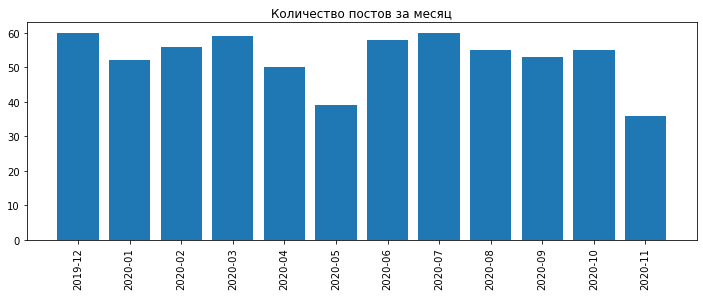

In [12]:
df1 = df.groupby(['y_m'])['id', 'views', 'likes', 'reposts', 'comments'].\
    agg({ 'id':'count', 'views':'sum', 'likes':'sum', 'reposts':'sum', 'comments':'sum' }).reset_index()

plt.figure(figsize=(12, 4))
plt.bar(df1['y_m'], df1['id'])
plt.xticks(rotation=90)
plt.title('Количество постов за месяц', fontsize='large')
plt.show()

In [13]:
# Лайки, просмотры и репосты на 1 пост
df1['views'] = df1['views'] / df1['id']
df1['likes'] = df1['likes'] / df1['id']
df1['reposts'] = df1['reposts'] / df1['id']
df1['comments'] = df1['comments'] / df1['id']

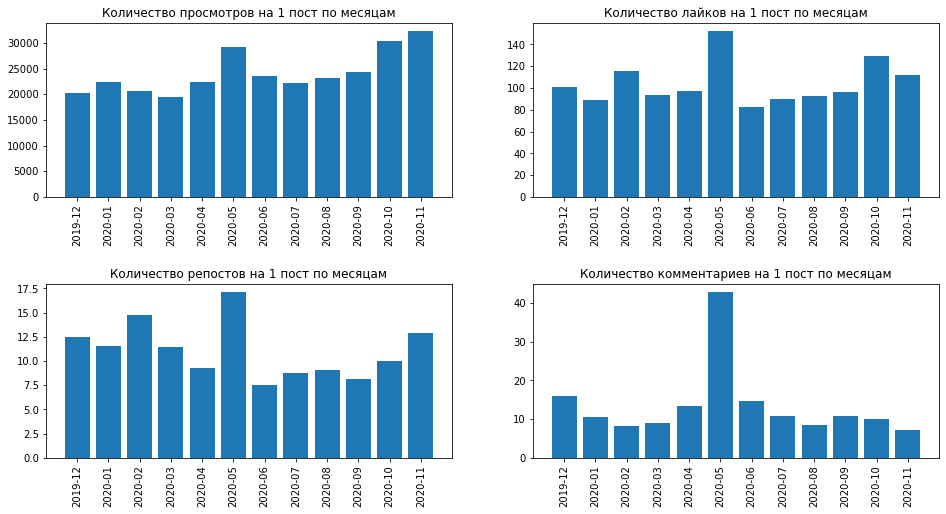

In [14]:
fig = plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.bar(df1['y_m'], df1['views'])
plt.title('Количество просмотров на 1 пост по месяцам', fontsize='large')
plt.xticks(rotation=90)

plt.subplot(2, 2, 2)
plt.bar(df1['y_m'], df1['likes'])
plt.title('Количество лайков на 1 пост по месяцам', fontsize='large')
plt.xticks(rotation=90)

plt.subplot(2, 2, 3)
plt.bar(df1['y_m'], df1['reposts'])
plt.title('Количество репостов на 1 пост по месяцам', fontsize='large')
plt.xticks(rotation=90)

plt.subplot(2, 2, 4)
plt.bar(df1['y_m'], df1['comments'])
plt.title('Количество комментариев на 1 пост по месяцам', fontsize='large')
plt.xticks(rotation=90)

plt.subplots_adjust(hspace=0.5)
plt.show()

<ipython-input-15-efce28ee69fa>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df1 = df.groupby(['y_m'])['views', 'likes', 'reposts'].\


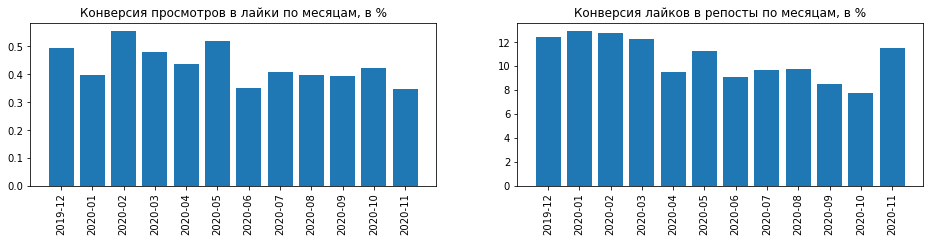

In [15]:
df1 = df.groupby(['y_m'])['views', 'likes', 'reposts'].\
    agg({ 'views':'sum', 'likes':'sum', 'reposts':'sum' }).reset_index()

df1['reposts'] = df1['reposts'] / df1['likes'] * 100
df1['likes'] = df1['likes'] / df1['views'] * 100

fig = plt.figure(figsize=(16, 3))

plt.subplot(1, 2, 1)
plt.bar(df1['y_m'], df1['likes'])
plt.title('Конверсия просмотров в лайки по месяцам, в %', fontsize='large')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
plt.bar(df1['y_m'], df1['reposts'])
plt.title('Конверсия лайков в репосты по месяцам, в %', fontsize='large')
plt.xticks(rotation=90)

plt.subplots_adjust(hspace=0.4)
plt.show()

Интерес к ресурсу (количество просмотров записей) начал активно рости начиная с апреля 2020 года. Можно отметить резкое увеличение просмотров в мае. На данный момент максимум наблюдается в ноябре 2020г. Аудитория Паблика по просмотрам увеличилась за год более чем в полтора раза.

Однако, это не отразилось на активности пользователей - на количестве лайков, репостов и комментариев. Всплеск наблюдается в мае 2020г. 

Как следствие сохранения количества активных действий на фоне роста просмотров, наблюдается некоторое снижение конверсии просмотров в лайки и в репосты.

### 2. Показатели активности в зависимости от времени дня месяца

In [16]:
df2 = df.groupby(['day'])['id', 'views', 'likes', 'reposts', 'comments'].\
    agg({ 'id':'count', 'id':'count', 'views':'sum', 'likes':'sum', 'reposts':'sum', 'comments':'sum' }).reset_index()

<ipython-input-16-90d899191f31>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df2 = df.groupby(['day'])['id', 'views', 'likes', 'reposts', 'comments'].\


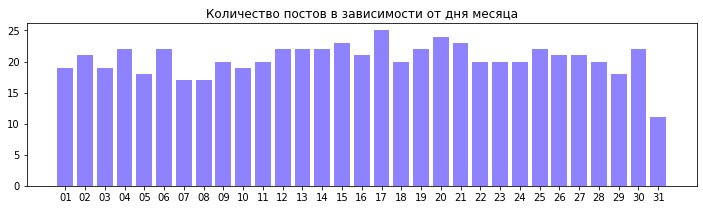

In [17]:
plt.figure(figsize=(12, 3))
plt.bar(df2['day'], df2['id'], color='#8e82fe')
plt.title('Количество постов в зависимости от дня месяца', fontsize='large')
plt.show()

In [18]:
# Лайки, просмотры и репосты на 1 пост
df2['views'] = df2['views'] / df2['id']
df2['likes'] = df2['likes'] / df2['id']
df2['reposts'] = df2['reposts'] / df2['id']
df2['comments'] = df2['comments'] / df2['id']

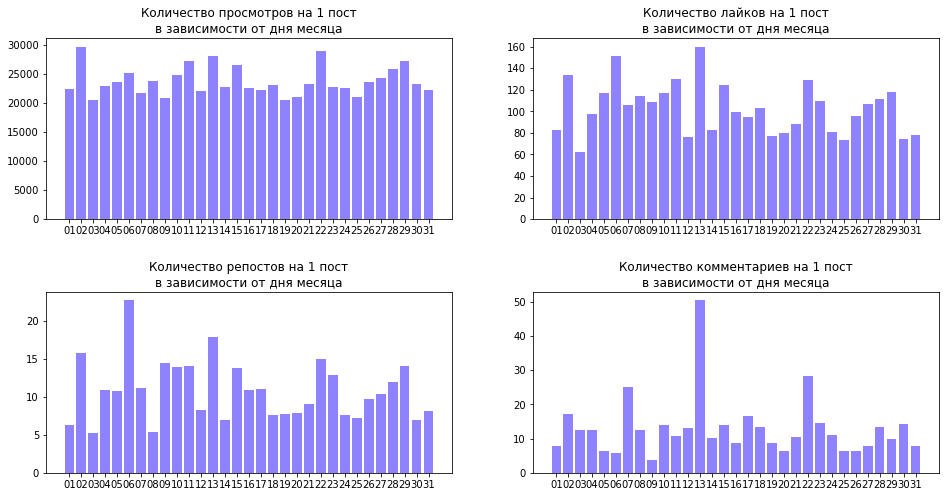

In [19]:
fig = plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.bar(df2['day'], df2['views'], color='#8e82fe')
plt.title('Количество просмотров на 1 пост\nв зависимости от дня месяца', fontsize='large')

plt.subplot(2, 2, 2)
plt.bar(df2['day'], df2['likes'], color='#8e82fe')
plt.title('Количество лайков на 1 пост\nв зависимости от дня месяца', fontsize='large')

plt.subplot(2, 2, 3)
plt.bar(df2['day'], df2['reposts'], color='#8e82fe')
plt.title('Количество репостов на 1 пост\nв зависимости от дня месяца', fontsize='large')

plt.subplot(2, 2, 4)
plt.bar(df2['day'], df2['comments'], color='#8e82fe')
plt.title('Количество комментариев на 1 пост\nв зависимости от дня месяца', fontsize='large')

plt.subplots_adjust(hspace=0.4)
plt.show()

<ipython-input-20-8a631cc0a1bd>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df2 = df.groupby(['day'])['views', 'likes', 'reposts'].\


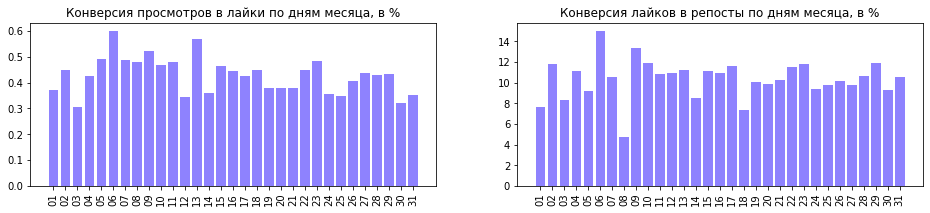

In [20]:
df2 = df.groupby(['day'])['views', 'likes', 'reposts'].\
    agg({ 'views':'sum', 'likes':'sum', 'reposts':'sum' }).reset_index()

df2['reposts'] = df2['reposts'] / df2['likes'] * 100
df2['likes'] = df2['likes'] / df2['views'] * 100

fig = plt.figure(figsize=(16, 3))

plt.subplot(1, 2, 1)
plt.bar(df2['day'], df2['likes'], color='#8e82fe')
plt.title('Конверсия просмотров в лайки по дням месяца, в %', fontsize='large')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
plt.bar(df2['day'], df2['reposts'], color='#8e82fe')
plt.title('Конверсия лайков в репосты по дням месяца, в %', fontsize='large')
plt.xticks(rotation=90)

plt.subplots_adjust(hspace=0.4)
plt.show()

На основании представленных диаграмм невозможно сделать вывод о наличии зависимости между активностью посетителей Паблика и днём месяца.

### 3. Показатели активности в зависимости от дня недели

In [21]:
df3 = df.groupby(['wd'])['id', 'views', 'likes', 'reposts', 'comments'].\
    agg({ 'id':'count', 'views':'sum', 'likes':'sum', 'reposts':'sum', 'comments':'sum' }).reset_index()

df3['weekday'] = pd.Categorical(df3.wd, categories=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
df3.sort_values('weekday', inplace=True)

<ipython-input-21-228126d1b93d>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df3 = df.groupby(['wd'])['id', 'views', 'likes', 'reposts', 'comments'].\


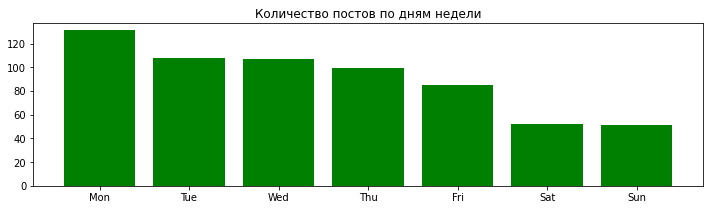

In [22]:
plt.figure(figsize=(12, 3))
plt.bar(df3['wd'], df3['id'], color='g')
plt.title('Количество постов по дням недели', fontsize='large')
plt.show()

In [23]:
# Лайки, просмотры и репосты на 1 пост
df3['views'] = df3['views'] / df3['id']
df3['likes'] = df3['likes'] / df3['id']
df3['reposts'] = df3['reposts'] / df3['id']
df3['comments'] = df3['comments'] / df3['id']

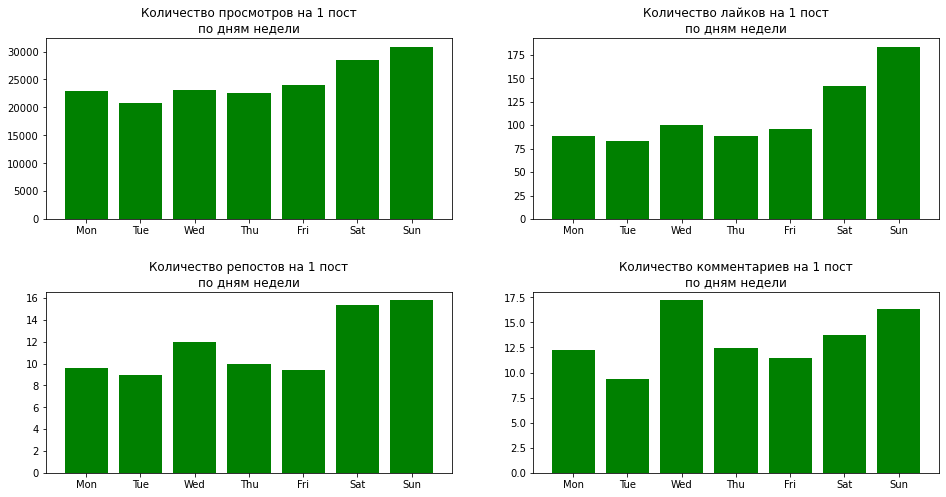

In [24]:
df3['weekday'] = pd.Categorical(df3.wd, categories=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
df3.sort_values('weekday', inplace=True)

fig = plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.bar(df3['wd'], df3['views'], color='g')
plt.title('Количество просмотров на 1 пост\nпо дням недели', fontsize='large')

plt.subplot(2, 2, 2)
plt.bar(df3['wd'], df3['likes'], color='g')
plt.title('Количество лайков на 1 пост\nпо дням недели', fontsize='large')

plt.subplot(2, 2, 3)
plt.bar(df3['wd'], df3['reposts'], color='g')
plt.title('Количество репостов на 1 пост\nпо дням недели', fontsize='large')

plt.subplot(2, 2, 4)
plt.bar(df3['wd'], df3['comments'], color='g')
plt.title('Количество комментариев на 1 пост\nпо дням недели', fontsize='large')

plt.subplots_adjust(hspace=0.4)
plt.show()

<ipython-input-25-727986ba3207>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df3 = df.groupby(['wd'])['views', 'likes', 'reposts'].\


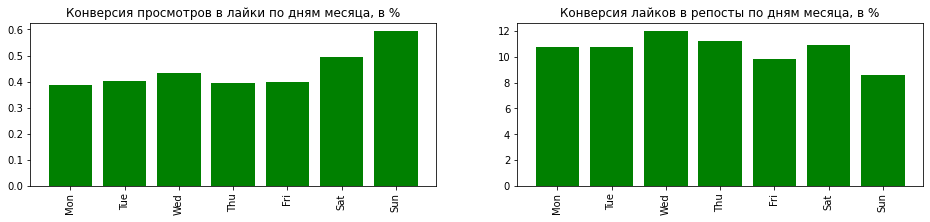

In [25]:
df3 = df.groupby(['wd'])['views', 'likes', 'reposts'].\
    agg({ 'views':'sum', 'likes':'sum', 'reposts':'sum' }).reset_index()

df3['weekday'] = pd.Categorical(df3.wd, categories=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
df3.sort_values('weekday', inplace=True)

df3['reposts'] = df3['reposts'] / df3['likes'] * 100
df3['likes'] = df3['likes'] / df3['views'] * 100

fig = plt.figure(figsize=(16, 3))

plt.subplot(1, 2, 1)
plt.bar(df3['wd'], df3['likes'], color='g')
plt.title('Конверсия просмотров в лайки по дням месяца, в %', fontsize='large')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
plt.bar(df3['wd'], df3['reposts'], color='g')
plt.title('Конверсия лайков в репосты по дням месяца, в %', fontsize='large')
plt.xticks(rotation=90)

plt.subplots_adjust(hspace=0.4)
plt.show()


Количество выложенных постов уменьшается от понедельника к выходным. Активность пользователей наоборот, в выходные возрастает. Также повышенной активностью выделяется среда.

### 4. Показатели активности в зависимости от времени суток

In [26]:
df4 = df.groupby(['time'])['id', 'views', 'likes', 'reposts', 'comments'].\
    agg({ 'id':'count', 'views':'sum', 'likes':'sum', 'reposts':'sum', 'comments':'sum' }).reset_index()

<ipython-input-26-e607f28a21cd>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df4 = df.groupby(['time'])['id', 'views', 'likes', 'reposts', 'comments'].\


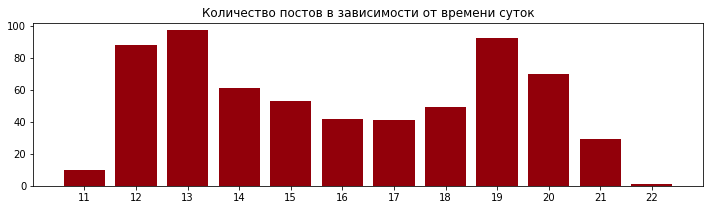

In [27]:
plt.figure(figsize=(12, 3))
plt.bar(df4['time'], df4['id'], color='#92000a')
plt.title('Количество постов в зависимости от времени суток', fontsize='large')
plt.show()

In [28]:
# Лайки, просмотры и репосты на 1 пост
df4['views'] = df4['views'] / df4['id']
df4['likes'] = df4['likes'] / df4['id']
df4['reposts'] = df4['reposts'] / df4['id']
df4['comments'] = df4['comments'] / df4['id']

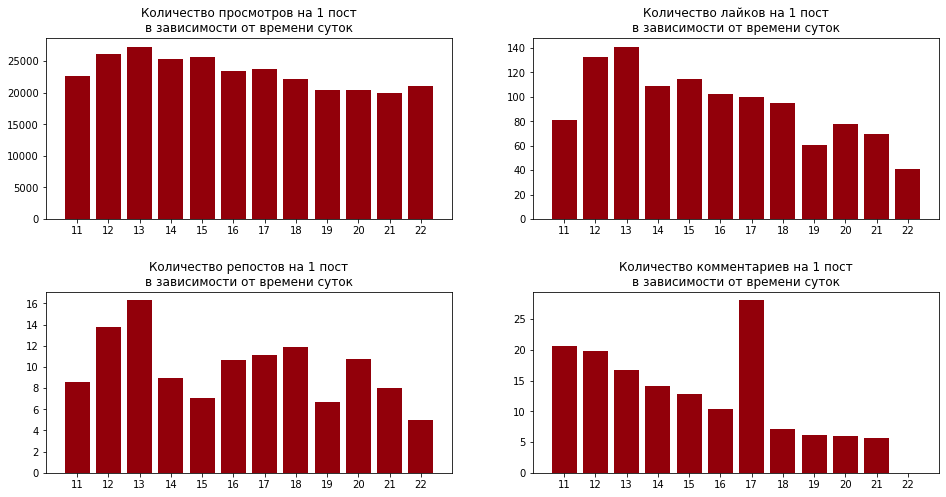

In [29]:
fig = plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.bar(df4['time'], df4['views'], color='#92000a')
plt.title('Количество просмотров на 1 пост\nв зависимости от времени суток', fontsize='large')

plt.subplot(2, 2, 2)
plt.bar(df4['time'], df4['likes'], color='#92000a')
plt.title('Количество лайков на 1 пост\nв зависимости от времени суток', fontsize='large')

plt.subplot(2, 2, 3)
plt.bar(df4['time'], df4['reposts'], color='#92000a')
plt.title('Количество репостов на 1 пост\nв зависимости от времени суток', fontsize='large')

plt.subplot(2, 2, 4)
plt.bar(df4['time'], df4['comments'], color='#92000a')
plt.title('Количество комментариев на 1 пост\nв зависимости от времени суток', fontsize='large')

plt.subplots_adjust(hspace=0.4)
plt.show()

<ipython-input-30-fee3c9a5ed0d>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df4 = df.groupby(['time'])['views', 'likes', 'reposts'].\


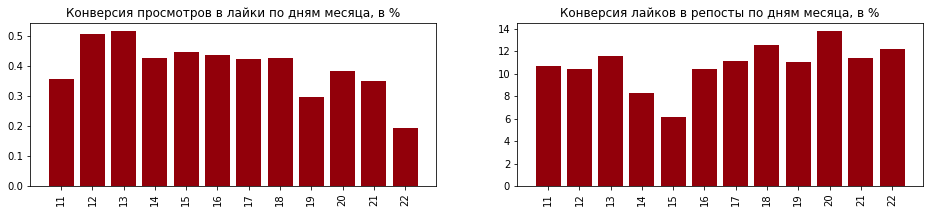

In [30]:
df4 = df.groupby(['time'])['views', 'likes', 'reposts'].\
    agg({ 'views':'sum', 'likes':'sum', 'reposts':'sum' }).reset_index()

df4['reposts'] = df4['reposts'] / df4['likes'] * 100
df4['likes'] = df4['likes'] / df4['views'] * 100

fig = plt.figure(figsize=(16, 3))

plt.subplot(1, 2, 1)
plt.bar(df4['time'], df4['likes'], color='#92000a')
plt.title('Конверсия просмотров в лайки по дням месяца, в %', fontsize='large')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
plt.bar(df4['time'], df4['reposts'], color='#92000a')
plt.title('Конверсия лайков в репосты по дням месяца, в %', fontsize='large')
plt.xticks(rotation=90)

plt.subplots_adjust(hspace=0.4)
plt.show()

Наибольшая часть постов выкладывается либо в обед, либо ближе к концу рабочего дня. Наибольшей популярностью у пользователй пользуются посты, выложенные в обед.

### 5. Показатели активности по рубрикам

In [31]:
# Пробежимся по всем записям датафрейма и оставим список уникальных хэштегов
list_of_tag = []
for str in df['text']:
    i = str.find('#')
    while i > 0:
        j = max( 0, str[i:].find(' ') )
        if j > 0:
            if str[i:i+j] not in list_of_tag:
                list_of_tag.append(str[i:i+j])
        else:
            if str[i:] not in list_of_tag:
                list_of_tag.append(str[i:])
        str = str[i:]
        i = str.find('#')
    
list_of_tag.sort()
list_of_tag

['#,',
 '#.\n\n#Статья_Skillbox',
 '#3D_графика_Skillbox',
 '#?',
 '#AIC_Skillbox',
 '#Avocard:',
 '#CG_Skillbox',
 '#Cовет_препода_Skillbox',
 '#Design_Battle_Skillbox',
 '#Dominos_Skillbox',
 '#FF4500)\nСмелый',
 '#HR_Совет_Skillbox',
 '#HR_совет_Skillbox',
 '#IMDb,',
 '#Mail_Design_Cup',
 '#OFFF_Moscow',
 '#PMIMoscow_Skillbox',
 '#Pixels_Fest',
 '#Russian_Creativity_Week',
 '#Russian_creative_week',
 '#SMDay',
 '#Skillbox',
 '#Skillbox_Дизайн',
 '#Skillbox_Маркетинг',
 '#Skillbox_Мркетинг',
 '#Skillbox_Программирование',
 '#Skillbox_РАНХиГС',
 '#Skillbox_Симпсоны',
 '#Skillbox_Сострадамус',
 '#Skillbox_Управление',
 '#Skillbox_в_закладки',
 '#Skillbox_вдохновляет',
 '#Skillbox_вопросы',
 '#Skillbox_геймдизайн',
 '#Skillbox_дизайн',
 '#Skillbox_игра',
 '#Skillbox_кейс',
 '#Skillbox_конкурс',
 '#Skillbox_маркетинг',
 '#Skillbox_программирование',
 '#Skillbox_управление',
 '#Skillboxвдохновляет',
 '#Skillboxподкаст',
 '#designworkout',
 '#skillbox_дизайн',
 '#skillbox_тренды',
 '#skill

Даже при беглом просмотре этого списка видно, насколько невнимательно работают редакторы Паблика, допуская ошибки в написании хэштегов. Из-за этих ошибок возникает дублирование, что затрудняет поиск нужных записей. А также исказит результаты последующего анализа.<br>
Пример: <br>
'#HR_Совет_Skillbox' и '#HR_совет_Skillbox' - слово 'Совет' написано в одном случае с заглавной буквы, в другом со строчной.<br>
'#Skillbox_Мркетинг', #В_закладки_Skllbox', '#Взакладки_Skillbox' - орфографическая ошибка

Проанализируем показатели активности по хэштегам, соответствующим четырем направлениям обучения в SkillBox

In [32]:
# Добавляем рубрику, анализируя поле 'text'
df['section'] = df['text'].apply( lambda x: 'Управление' if '#Skillbox_управление' in x else \
                                'Дизайн' if '#Skillbox_Дизайн' in x else \
                                'Маркетинг' if '#Skillbox_Маркетинг' in x else \
                                'Программирование' if '#Skillbox_программирование' in x else 'Прочее' )

In [33]:
df5 = df.groupby(['section'])['id', 'views', 'likes', 'reposts', 'comments'].\
    agg({ 'id':'count', 'views':'sum', 'likes':'sum', 'reposts':'sum', 'comments':'sum' }).reset_index()

df5 = df5[ df5['section'] != 'Прочее']

<ipython-input-33-c5fb862fd5a0>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df5 = df.groupby(['section'])['id', 'views', 'likes', 'reposts', 'comments'].\


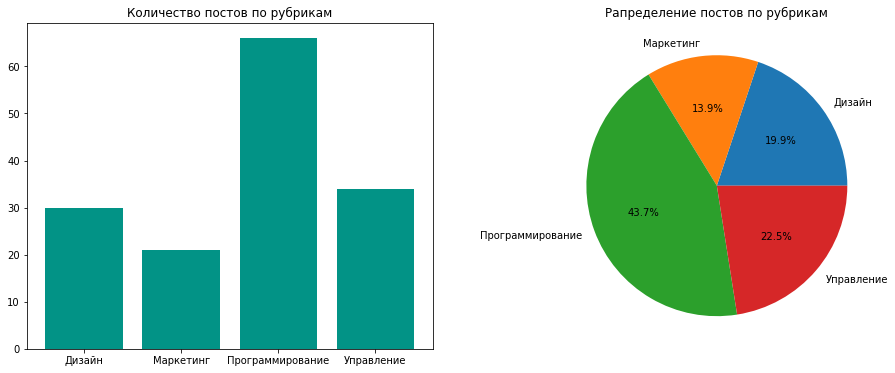

In [34]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.bar(df5['section'], df5['id'], color='#029386')
plt.title('Количество постов по рубрикам', fontsize='large')

plt.subplot(1, 2, 2)
plt.pie(df5['id'], labels=df5['section'], autopct='%1.1f%%')
plt.title('Рапределение постов по рубрикам', fontsize='large')

plt.show()

In [35]:
# Лайки, просмотры и репосты на 1 пост
df5['views'] = df5['views'] / df5['id']
df5['likes'] = df5['likes'] / df5['id']
df5['reposts'] = df5['reposts'] / df5['id']
df5['comments'] = df5['comments'] / df5['id']

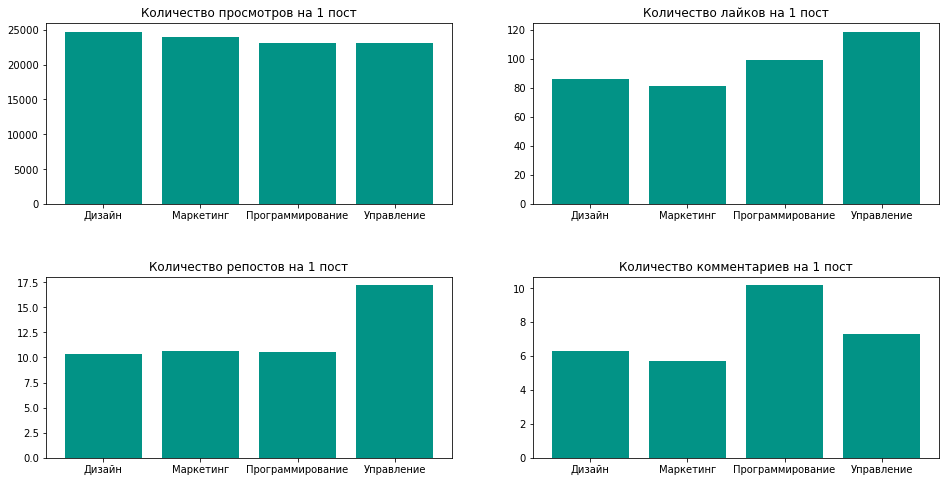

In [36]:
fig = plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.bar(df5['section'], df5['views'], color='#029386')
plt.title('Количество просмотров на 1 пост', fontsize='large')

plt.subplot(2, 2, 2)
plt.bar(df5['section'], df5['likes'], color='#029386')
plt.title('Количество лайков на 1 пост', fontsize='large')

plt.subplot(2, 2, 3)
plt.bar(df5['section'], df5['reposts'], color='#029386')
plt.title('Количество репостов на 1 пост', fontsize='large')

plt.subplot(2, 2, 4)
plt.bar(df5['section'], df5['comments'], color='#029386' )
plt.title('Количество комментариев на 1 пост', fontsize='large')

plt.subplots_adjust(hspace=0.4)
plt.show()

Наибольшее количество постов отведено напралению обучения "Программирование". Однако количество просмотров на 1 пост примерно одинаково по всем направлениям. Лайкают и репостят чаще по хэштегу "Управление", комметнтируют по хэштегу "Программирование".

### 6. Зависимость показателей активности друг от друга

In [37]:
print('Корреляция между:')
print('  Просмотрами и лайками       :', np.corrcoef(df['views'], df['likes'])[0][1])
print('  Просмотрами и репостами     :', np.corrcoef(df['views'], df['reposts'])[0][1])
print('  Просмотрами и комментариями :', np.corrcoef(df['views'], df['comments'])[0][1])
print('  Репостами и лайками         :', np.corrcoef(df['reposts'], df['likes'])[0][1])
print('  Репостами и комментариями   :', np.corrcoef(df['reposts'], df['comments'])[0][1])
print('  Комменатриями и лайками     :', np.corrcoef(df['comments'], df['likes'])[0][1])

Корреляция между:
  Просмотрами и лайками       : 0.7781902860854188
  Просмотрами и репостами     : 0.6432156178239722
  Просмотрами и комментариями : 0.33872114075937537
  Репостами и лайками         : 0.8665250558745541
  Репостами и комментариями   : 0.27985080970404147
  Комменатриями и лайками     : 0.3174898615358999


In [38]:
print(df['likes'].sum() / df['views'].sum() * 100 )
print(df['reposts'].sum() / df['views'].sum() * 100 )
print(df['comments'].sum() / df['views'].sum() * 100 )
print(df['reposts'].sum() / df['likes'].sum() * 100 )
print(df['comments'].sum() / df['likes'].sum() * 100 )
print(df['reposts'].sum() / df['comments'].sum() * 100 )

0.4320445059922402
0.04582602660211155
0.054553526515302195
10.60678378419991
12.626830282221436
84.00195098158761


Очень высокая степень корреляции между репостами и лайками. 
В среднем же 12.6% лайкнувших запись напишет комментарий, 10.6% её репостнет. 84% прокомментировавших запись сделает репост.

### 7. Изменение показателей активности за год. Сравниваем октябрь 2019г. и октябрь 2020г.

In [39]:
df_small['y_m'] = df_small['date'].apply( lambda x: x[:4])

df7_2019 = df_small[ df_small['y_m'] == '2019' ]
df7_2019 = df7_2019.groupby(['y_m', 'day'])['id', 'views', 'likes', 'reposts', 'comments'].\
    agg({ 'id':'count', 'views':'sum', 'likes':'sum', 'reposts':'sum', 'comments':'sum' }).reset_index()
df7_2019.loc[30] = ['2019', '20', 0, 0, 0, 0, 0]
df7_2019.sort_values(by=['day'], inplace=True)

df7_2020 = df_small[ df_small['y_m'] == '2020' ]
df7_2020 = df7_2020.groupby(['y_m', 'day'])['id', 'views', 'likes', 'reposts', 'comments'].\
    agg({ 'id':'count', 'views':'sum', 'likes':'sum', 'reposts':'sum', 'comments':'sum' }).reset_index()

<ipython-input-39-00958ba693b4>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df7_2019 = df7_2019.groupby(['y_m', 'day'])['id', 'views', 'likes', 'reposts', 'comments'].\
<ipython-input-39-00958ba693b4>:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df7_2020 = df7_2020.groupby(['y_m', 'day'])['id', 'views', 'likes', 'reposts', 'comments'].\


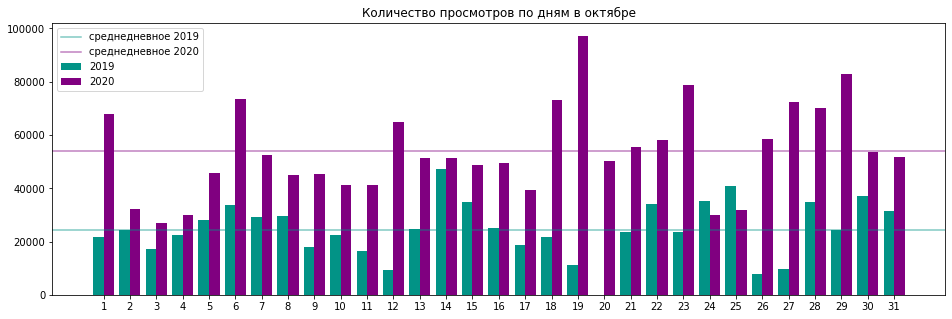

Увеличение количества просмотров за год:  2.2


In [40]:
plt.figure(figsize=(16, 5))
x = np.arange(1, 32)
plt.bar(x-0.2, df7_2019['views'], 0.4, color='#029386')
plt.bar(x+0.2, df7_2020['views'], 0.4, color='purple')
plt.xticks(list(range(1, 32)))

plt.axhline(y=df7_2019['views'].mean(), color='#029386', alpha=0.5)
plt.axhline(y=df7_2020['views'].mean(), color='purple', alpha=0.5)

plt.legend(['среднедневное 2019', 'среднедневное 2020', '2019', '2020'])
plt.title('Количество просмотров по дням в октябре', fontsize='large')

plt.show()

print('Увеличение количества просмотров за год: ', round(df7_2020['views'].sum() / df7_2019['views'].sum(), 1))

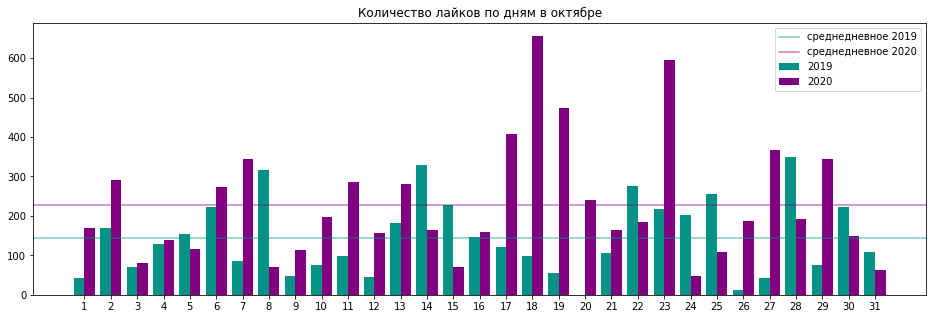

Увеличение количества лайков за год:  1.6


In [41]:
plt.figure(figsize=(16, 5))
x = np.arange(1, 32)
plt.bar(x-0.2, df7_2019['likes'], 0.4, color='#029386')
plt.bar(x+0.2, df7_2020['likes'], 0.4, color='purple')
plt.xticks(list(range(1, 32)))

plt.axhline(y=df7_2019['likes'].mean(), color='#029386', alpha=0.5)
plt.axhline(y=df7_2020['likes'].mean(), color='purple', alpha=0.5)

plt.legend(['среднедневное 2019', 'среднедневное 2020', '2019', '2020'])
plt.title('Количество лайков по дням в октябре', fontsize='large')

plt.show()

print('Увеличение количества лайков за год: ', round(df7_2020['likes'].sum() / df7_2019['likes'].sum(), 1))

За год резко, в 2.2 раза выросло количество просмотров, в 1.6 раза выросло количество пользователей, лайкнувших записи Паблика.

### 8. Резюме

За прошедший год почти в два раза выросла активность посетителей Паблика SkillBox в "В Контакте". Из причин можно выделить пандемию коронавируса, подогревшей интерес к онлайн-обучению. У части людей на карантине появилось свободное время, которое было решено потратить на обучение. Другая часть была вынуждена начать обучение новой профессии по причине увольнения. В этой связи можно особенно выделить май 2020.